Exploratory Data Analysis of the merged CSV file.

# Table of Contents

1. [Introduction](#introduction)
2. [Data Preview](#data-preview)
3. [Correlation Analysis](#correlation-analysis)
4. [Exploring COVID-19 Case Trends](#exploring-covid-19-case-trends)
5. [Outlier and Data Quality Investigation](#outlier-and-data-quality-investigation)
6. [Cumulative Case Trends](#cumulative-case-trends)
7. [Data Consistency Checks](#data-consistency-checks)
8. [Summary and Next Steps](#summary-and-next-steps)

# <a name="introduction"></a>Introduction

Welcome to the Exploratory Data Analysis (EDA) of the merged COVID-19 dataset for Indian states. In this notebook, we will explore the data, visualize trends, check for correlations, and investigate data quality issues to better understand the dataset and prepare it for modeling.


# <a name="data-preview"></a>Data Preview

Let's start by loading the merged dataset and previewing its structure. This helps us understand what columns are available and inspect a random row for a quick sense-check.


In [31]:
import pandas as pd

# Read the merged CSV file from the processed folder
df = pd.read_csv("../Data/Processed/merged_data.csv")

# Display a row from the DataFrame
print(df.sample(1))

# Display the columns of the DataFrame
print(df.columns)

            state       dates  cum_positive_cases  cum_positivity_rate  \
12685  Puducherry  2021-01-07             38369.0             7.532313   

       daily_positive_cases  cum_recovered  daily_recovered  cum_deceased  \
12685                  35.0        37374.0             47.0         636.0   

       daily_deceased  daily_positivity_rate  ...  district_hospitals  \
12685             1.0               1.036423  ...                 4.0   

       public_health_facilities  public_beds  rural_hospitals  rural_beds  \
12685                      53.0       4462.0              3.0        96.0   

       urban_hospitals  urban_beds  Collection Site  Government Laboratory  \
12685             11.0      3473.0                0                      1   

       Private Laboratory  
12685                   0  

[1 rows x 43 columns]
Index(['state', 'dates', 'cum_positive_cases', 'cum_positivity_rate',
       'daily_positive_cases', 'cum_recovered', 'daily_recovered',
       'cum_deceased'

# <a name="correlation-analysis"></a>Correlation Analysis

Next, we examine the relationships between numerical features using a correlation matrix. This helps us identify highly correlated variables, which can inform feature selection and highlight potential multicollinearity issues.


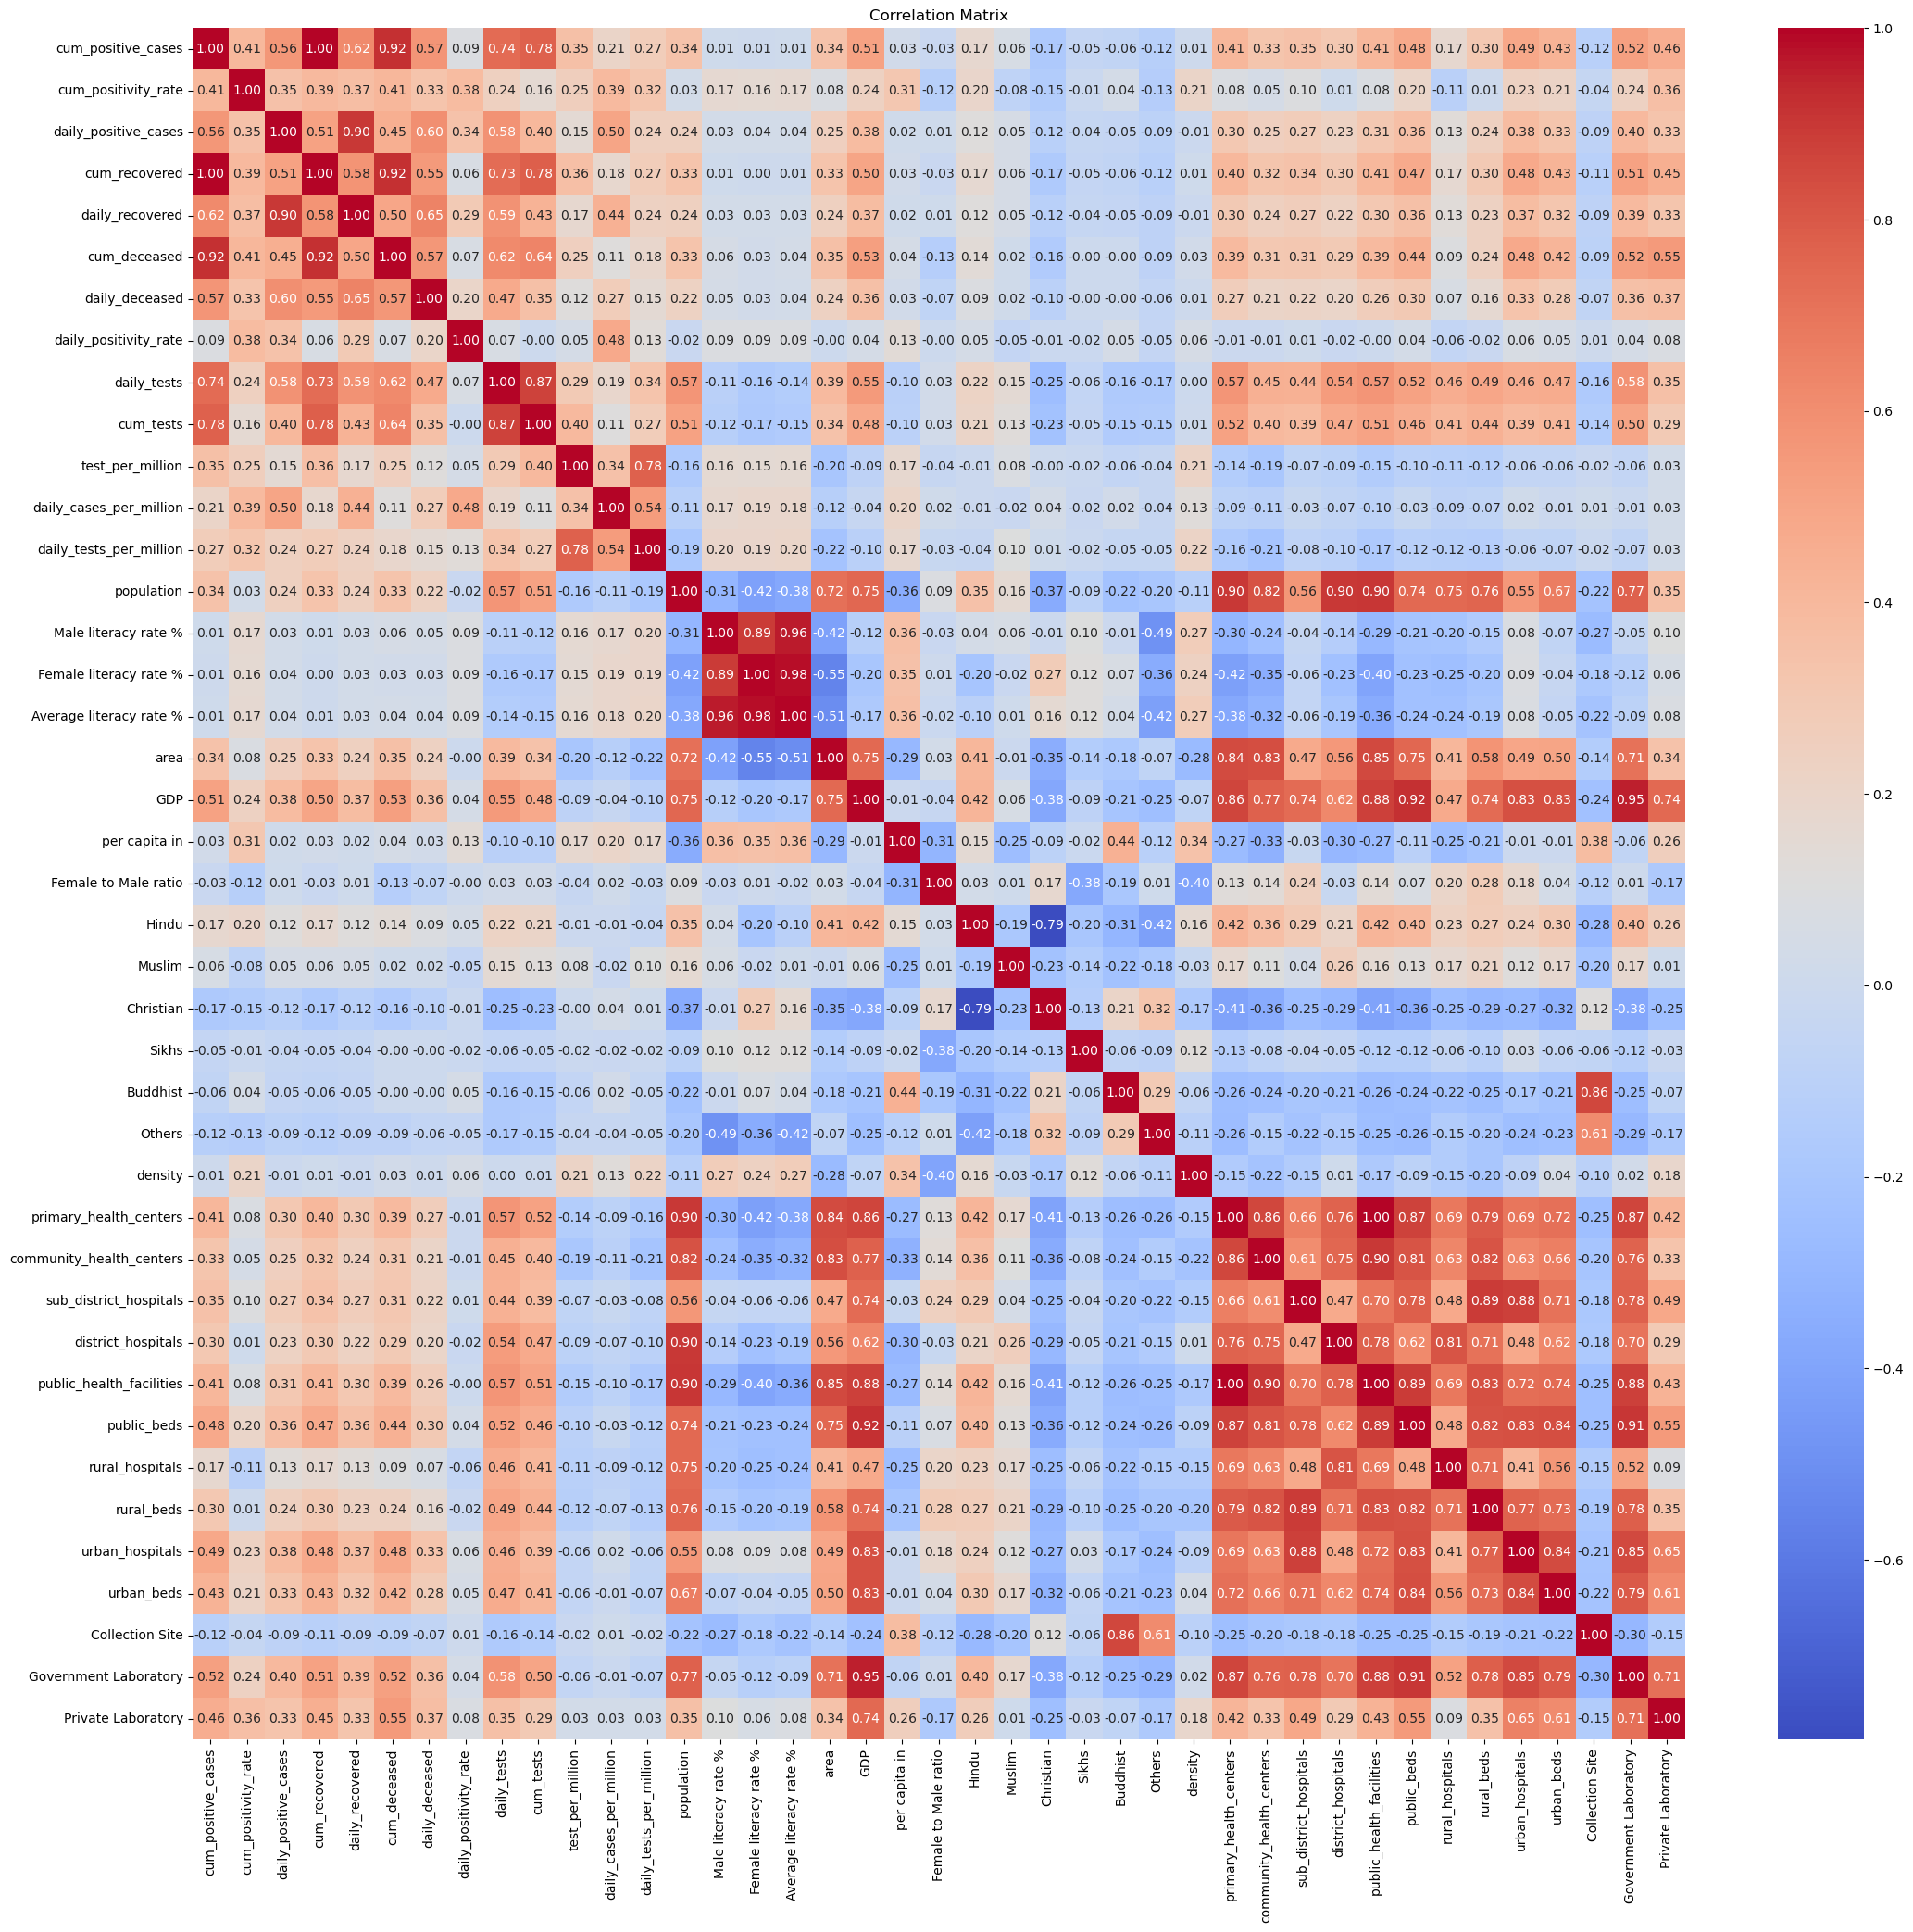

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df.corr(numeric_only=True)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(26, 24))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

columns are confusing - cum positivity rate, daily positive cases, cum recovered, cum deceased daily positivity rate
we need  to remove them as they have high corr but the interfere with the question
we can see economic corr where if the gdp is higher then there are more gov and private labs, cristians and hindus dont get along well, and the bigger the are the more there are facilities



# <a name="exploring-covid-19-case-trends"></a>Exploring COVID-19 Case Trends

We now visualize the daily positive COVID-19 cases for each state over time. This allows us to observe the temporal dynamics of the pandemic across different regions and identify peaks, trends, and anomalies.


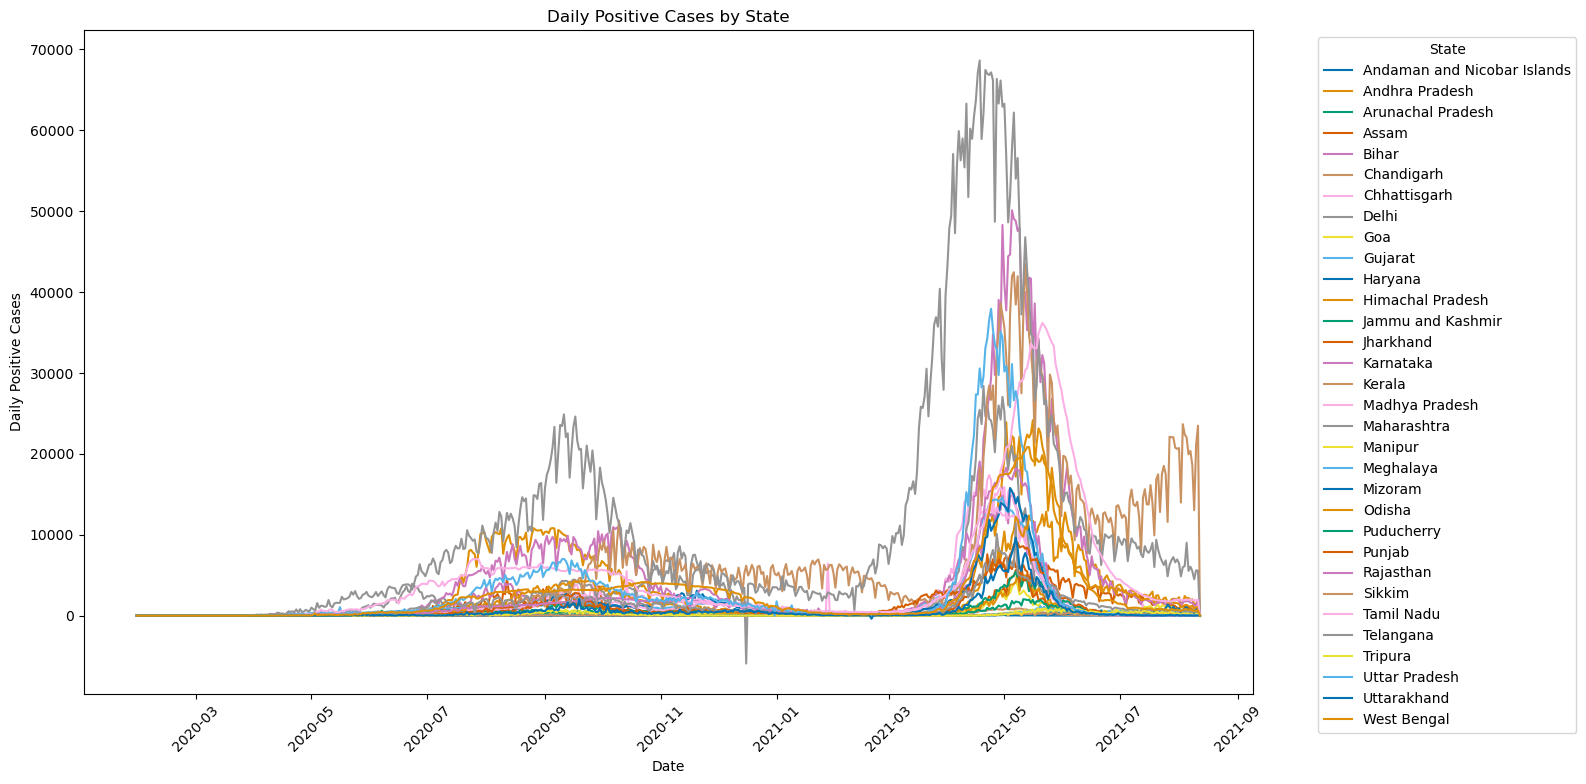

In [33]:
# Ensure 'dates' is datetime
df['dates'] = pd.to_datetime(df['dates'])

plt.figure(figsize=(16, 8))
palette = sns.color_palette("colorblind", n_colors=len(df['state'].unique()))

for i, state in enumerate(df['state'].unique()):
    state_data = df[df['state'] == state]
    plt.plot(state_data['dates'], state_data['daily_positive_cases'], label=state, color=palette[i])

plt.title('Daily Positive Cases by State')
plt.xlabel('Date')
plt.ylabel('Daily Positive Cases')
plt.xticks(rotation=45)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

After plotting, we noticed some negative values in daily positive cases, which are not possible in reality. Here, we identify and display these anomalies to understand their context and plan for data cleaning.


In [34]:
# print the state and date where 'daily_positive_cases' is negative
negative_cases = df[df['daily_positive_cases'] < 0][['state', 'dates', 'daily_positive_cases']]
if not negative_cases.empty:
    print("Negative daily positive cases found:")
    print(negative_cases)

Negative daily positive cases found:
             state      dates  daily_positive_cases
9858   Maharashtra 2020-12-16               -5914.0
10798    Meghalaya 2020-06-17                  -1.0
13009       Punjab 2020-05-15                  -3.0
14187       Sikkim 2020-07-10                 -13.0
15816      Tripura 2020-05-17                  -2.0
17217  Uttarakhand 2021-02-20                -374.0


This is a problem.
if we train a regression model using the lag configuration we might "throw it off" as suddenly the count of the cumulative positive is down 
We can select a window before and after and find a mean of sick people per day and shift the numbers so they match, either up after the negative value or down before the negative value



# <a name="cumulative-case-trends"></a>Cumulative Case Trends

To further understand the progression of the pandemic, we plot the cumulative positive cases for each state on a logarithmic scale. This visualization helps reveal growth patterns and highlights any inconsistencies or sudden drops in the data.


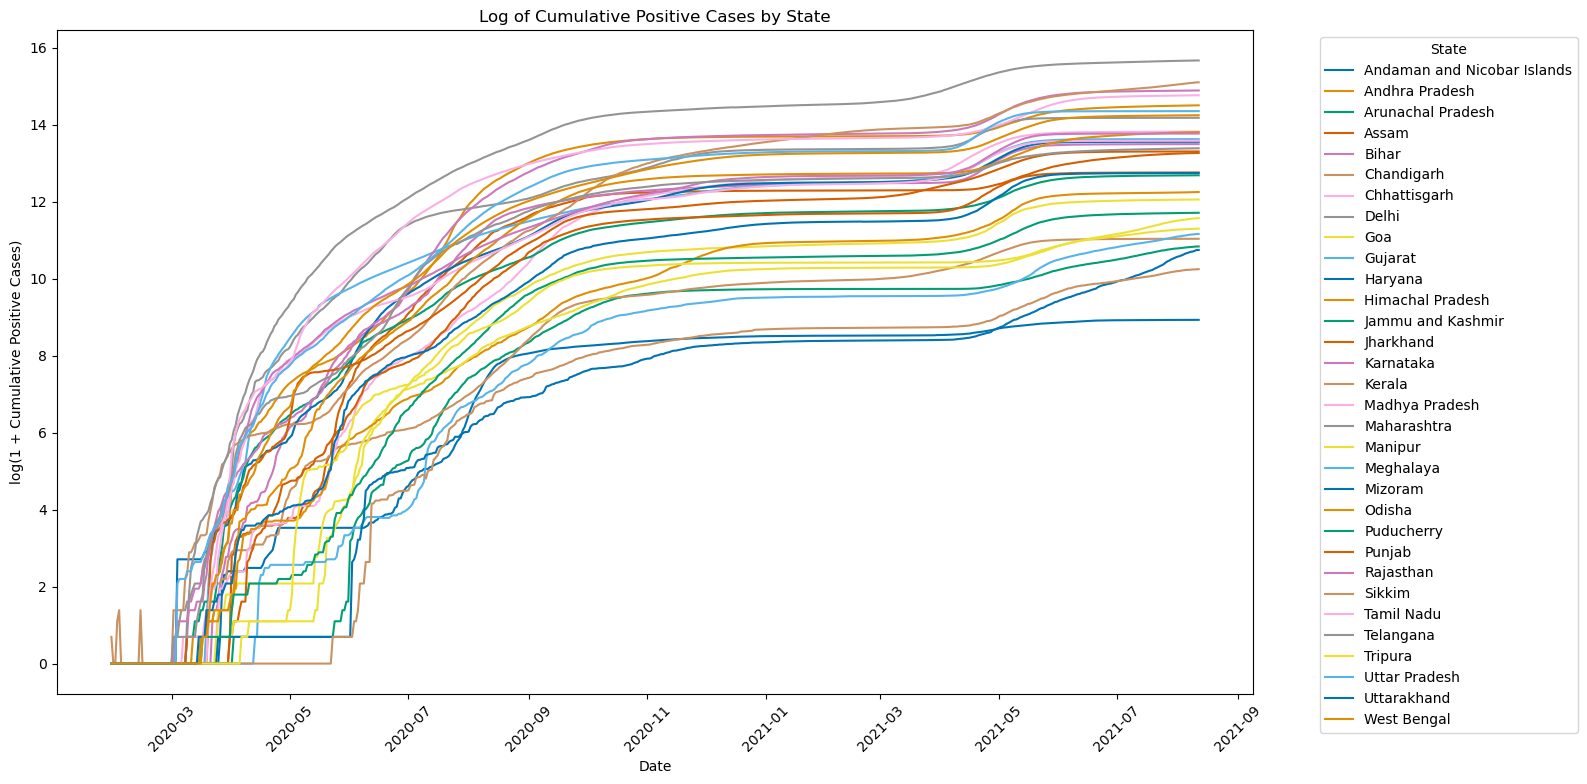

In [35]:
import numpy as np

# plot the cumulative positive cases by state
plt.figure(figsize=(16, 8))
palette = sns.color_palette("colorblind", n_colors=len(df['state'].unique()))

for i, state in enumerate(df['state'].unique()):
    state_data = df[df['state'] == state]
    plt.plot(
        state_data['dates'],
        np.log1p(state_data['cum_positive_cases']),
        label=state,
        color=palette[i]
    )

plt.title('Log of Cumulative Positive Cases by State')
plt.xlabel('Date')
plt.ylabel('log(1 + Cumulative Positive Cases)')
plt.xticks(rotation=45)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

A well-behaved cumulative case series should be monotonically increasing. Here, we count how many times, for each state, the cumulative positive cases decrease from one day to the next. This helps us pinpoint data corrections or reporting errors that need to be addressed.


In [36]:
# count per state how many times the cumulative positive cases are bigger than the day after
cumulative_positive_cases_next_day = df.groupby('state').apply(
    lambda x: (x['cum_positive_cases'] > x['cum_positive_cases'].shift(-1)).sum()
).reset_index(name='count')
print("Count of states where cumulative positive cases are greater than the next day:")
print(cumulative_positive_cases_next_day)

Count of states where cumulative positive cases are greater than the next day:
                          state  count
0   Andaman and Nicobar Islands      0
1                Andhra Pradesh      0
2             Arunachal Pradesh      0
3                         Assam      0
4                         Bihar      0
5                    Chandigarh      0
6                  Chhattisgarh      0
7                         Delhi      0
8                           Goa      0
9                       Gujarat      0
10                      Haryana      0
11             Himachal Pradesh      0
12            Jammu and Kashmir      0
13                    Jharkhand      0
14                    Karnataka      0
15                       Kerala      3
16               Madhya Pradesh      0
17                  Maharashtra      1
18                      Manipur      0
19                    Meghalaya      1
20                      Mizoram      0
21                       Odisha      0
22                   Pud

So the problem is not systematic and only 3 points in kerala are problematic
After careful examination there was a problem in how we merged the data, where we should have filled the missing values not with 0 but with the value that we met so far.
good thing there is EDA for this

# <a name="summary-and-next-steps"></a>Summary and Next Steps

**Summary of actions to take:**
- Remove or adjust problematic columns.
- Correct data points where the cumulative case count decreases.
- Specifically address the identified issues in Kerala's data.

By performing these steps, we ensure the dataset is clean and reliable for downstream modeling and analysis.